In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

import os
import pickle
import random
import sys

from scipy.stats import ttest_ind
from torkin import TorKin

from config import Config
cfg = Config()

plt.rcParams['font.size'] = 18
plt.rc('font', size=18)
plt.rc('legend', fontsize=14)
label_fontsize = 14

In [2]:
root_dir = "/home/arash/catkin_ws/src/feedback_controller/fbc/neural_network/results/"
# ds_name = "trajs:72_blocks:3" + "_triangle_v_scarce" #"_triangle_v"
ds_name = "trajs:500_blocks:3" + "_random"
# ds_name = "triangle"
ds_type = "interp_0.95" #"interp_0.85" #"extrap_0.85"
# noise = "0.008_noise"
model_name = f"2+2l_lat:sub-nvel_1e-05"

model_params_list = [6.037, 12.053, 24.085] #, 36.117]
episode_no = 4000

kin = TorKin()

No data file named /home/erhan/catkin_ws/src/erhtor_work/tormain/Resources/larm60.txt
bodypart structure for larm is constructed.
No data file named /home/erhan/catkin_ws/src/erhtor_work/tormain/Resources/rarm60.txt
bodypart structure for rarm is constructed.
bodypart structure for head is constructed.


### Example

In [ ]:
file_root_dir = root_dir +\
    f"{ds_name}_{model_params_list[-1]}K_{ds_type}/ep:10000/on_{model_name}" + "_True" + "_3l_base"

file_path = os.path.join(file_root_dir, "perf.csv")
df = pd.read_csv(file_path)  

In [ ]:
df.head()

In [ ]:
df.loc[3, 'dnfc_dtw']

In [ ]:
# df['dnfc_succ'] *= 100.0
# df['basel_succ'] *= 100.0
df.head()

In [ ]:
df['train_round'] = df.groupby('eps_num').cumcount() + 1
df.head(10)

In [ ]:
df.shape

In [ ]:
# df = df[df["eps_num"] <= 32]
# df.shape

In [ ]:
dnfc_succ_cases = df[df['dnfc_succ'].astype(int) == 1]
print(dnfc_succ_cases.head())
print(len(dnfc_succ_cases))

In [ ]:
basel_succ_cases = df[df['basel_succ'].astype(int) == 1]
print(basel_succ_cases.head())
print(len(basel_succ_cases))

In [ ]:
print(dnfc_succ_cases['dnfc_dtw'].tolist())
print(dnfc_succ_cases['dnfc_dtw'].mean())
print(dnfc_succ_cases['dnfc_dtw'].std())

In [ ]:
print(basel_succ_cases['basel_dtw'].tolist())
print(basel_succ_cases['basel_dtw'].mean())
print(basel_succ_cases['basel_dtw'].std())

In [ ]:
round_means_dnfc_succ = dnfc_succ_cases.groupby('train_round')[['dnfc_succ', 
                                                                'basel_succ', 
                                                                'dnfc_dtw', 
                                                                'basel_dtw']
                                                                ].mean()

print(round_means_dnfc_succ)
print(len(round_means_dnfc_succ))
print("===")
print(round_means_dnfc_succ.mean())

In [ ]:
dnfc_succ_cases

In [ ]:
round_means_basel_succ = basel_succ_cases.groupby('train_round')[['dnfc_succ', 
                                                                  'basel_succ', 
                                                                  'dnfc_dtw', 
                                                                  'basel_dtw']
                                                                  ].mean()

print(round_means_basel_succ)
print(len(round_means_basel_succ))
print("===")
print(round_means_basel_succ.mean())

In [ ]:
round_means = df.groupby('train_round')[['dnfc_succ', 'basel_succ',
                                         'dnfc_dtw', 'basel_dtw']].mean()

round_means

In [ ]:
overall_mean = round_means.mean()
overall_std = round_means.std()
print(overall_mean)
print("---")
print(overall_std)

In [ ]:
dnfc_succ = round_means['dnfc_succ'].tolist()
basel_succ = round_means['basel_succ'].tolist()

dnfc_mean = np.mean(dnfc_succ)
basel_mean = np.mean(basel_succ)

# Scatter plot
plt.figure(figsize=(10, 6))
train_rounds = np.arange(1, len(dnfc_succ)+1)

# Plot scatter points
plt.scatter(train_rounds, dnfc_succ, color='blue', label='dnfc_succ', marker='o')
plt.scatter(train_rounds, basel_succ, color='orange', label='basel_succ', marker='s')

# Add mean lines
plt.axhline(dnfc_mean, color='blue', linestyle='dashed', linewidth=2, 
            label=f'dnfc_succ mean: {dnfc_mean:.2f}')
plt.axhline(basel_mean, color='orange', linestyle='dashed', linewidth=2, 
            label=f'basel_succ mean: {basel_mean:.2f}')

# Labels and legend
plt.xlabel('Train Round')
plt.ylabel('Success Rate')
plt.title('Scatter Plot of dnfc_succ and basel_succ')
plt.xticks(train_rounds)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.savefig(os.path.join(os.getcwd(), "paper/each_model.png"))
plt.show()

In [ ]:
df.shape

## Performance

In [3]:
stats_model = {
    'size': 0,
    'succ_mean': [],
    'succ_std': [],
    'dtw_mean': [],
    'dtw_std': [],

    'succ_arr' : [],
    'dtw_arr' : [],

    'succ_num' : [],
    'eps_num' : [],

    'succ_dtw_mean' : [],
    'succ_dtw_std' : [],
    'succ_dtw_num' : [],
}

stats_base = {
    'size': 0,
    'succ_mean': [],
    'succ_std': [],
    'dtw_mean': [],
    'dtw_std': [],

    'succ_arr' : [],
    'dtw_arr' : [],

    'succ_num' : [],
    'eps_num' : [],

    'succ_dtw_mean' : [],
    'succ_dtw_std' : [],
    'succ_dtw_num' : [],
}

stats_abl = {
    'size': 0,
    'succ_mean': [],
    'succ_std': [],
    'dtw_mean': [],
    'dtw_std': [],

    'succ_arr' : [],
    'dtw_arr' : [],

    'succ_num' : [],
    'eps_num' : [],

    'succ_dtw_mean' : [],
    'succ_dtw_std' : [],
    'succ_dtw_num' : [],
}

In [4]:
def get_mean_std_across_trains(df):
    round_means = df.groupby('train_round')[['dnfc_succ', 'basel_succ', 
                                             'dnfc_dtw', 'basel_dtw']
                                             ].mean()
    n = len(round_means)
    print("N =", n)
    overall_mean = round_means.mean()
    overall_std = round_means.std()
    return overall_mean, overall_std, round_means

In [5]:
for num_params in model_params_list:
    model_dir = os.path.join(root_dir, f"{ds_name}_{num_params}K_{ds_type}/ep:{episode_no}/")
    for is_not_abl in [True, False]:
        file_dir = os.path.join(model_dir, f"on_{model_name}_{is_not_abl}" + f"_3l_base")
        file_path = os.path.join(file_dir, "perf.csv")
        df = pd.read_csv(file_path)  
        print("df shape", df.shape)
        print("path", file_path, end="\n===")
        
        # df['dnfc_succ'] *= 100.0
        # df['basel_succ'] *= 100.0

        df['train_round'] = df.groupby('eps_num').cumcount() + 1

        dnfc_succ_cases = df[df['dnfc_succ'].astype(int) == 1]
        basel_succ_cases = df[df['basel_succ'].astype(int) == 1]
        # df = df[df["eps_num"] <= 32]
        overall_mean, overall_std, round_means = get_mean_std_across_trains(df)
        overall_mean_dnfc, overall_std_dnfc, round_means_dnfc = get_mean_std_across_trains(dnfc_succ_cases)
        overall_mean_base, overall_std_base, round_means_base = get_mean_std_across_trains(basel_succ_cases)

        if is_not_abl:
            stats_model['succ_mean'].append(overall_mean['dnfc_succ'])
            stats_base['succ_mean'].append(overall_mean['basel_succ'])
            stats_model['dtw_mean'].append(overall_mean['dnfc_dtw'])
            stats_base['dtw_mean'].append(overall_mean['basel_dtw'])

            stats_model['succ_arr'].append(round_means['dnfc_succ'].tolist()) #dnfc_succ.tolist())
            stats_model['dtw_arr'].append(round_means['dnfc_dtw'].tolist()) #dnfc_dtw.tolist())

            stats_model['succ_std'].append(overall_std['dnfc_succ'])
            stats_base['succ_std'].append(overall_std['basel_succ'])
            stats_model['dtw_std'].append(overall_std['dnfc_dtw'])
            stats_base['dtw_std'].append(overall_std['basel_dtw'])

            stats_base['succ_arr'].append(round_means['basel_succ'].tolist()) #basel_succ.tolist())
            stats_base['dtw_arr'].append(round_means['basel_dtw'].tolist()) #basel_dtw.tolist())

            stats_model['succ_num'].append(len(dnfc_succ_cases))
            stats_base['succ_num'].append(len(basel_succ_cases))
            stats_model['eps_num'].append(len(df))
            stats_base['eps_num'].append(len(df))

            stats_model['succ_dtw_mean'].append(overall_mean_dnfc["dnfc_dtw"])
            stats_model['succ_dtw_std'].append(overall_std_dnfc["dnfc_dtw"])
            stats_model['succ_dtw_num'].append(len(round_means_dnfc))
            stats_base['succ_dtw_mean'].append(overall_mean_base["basel_dtw"])
            stats_base['succ_dtw_std'].append(overall_std_base["basel_dtw"])
            stats_base['succ_dtw_num'].append(len(round_means_base))
        else:
            stats_abl['succ_mean'].append(overall_mean['dnfc_succ'])
            stats_abl['succ_std'].append(overall_std['dnfc_succ'])
            stats_abl['dtw_mean'].append(overall_mean['dnfc_dtw'])
            stats_abl['dtw_std'].append(overall_std['dnfc_dtw'])

            stats_abl['succ_arr'].append(round_means['dnfc_succ'].tolist()) #dnfc_succ.tolist())
            stats_abl['dtw_arr'].append(round_means['dnfc_dtw'].tolist()) #dnfc_dtw.tolist())

            stats_abl['succ_num'].append(len(dnfc_succ_cases))
            stats_abl['eps_num'].append(len(df))
            stats_abl['succ_dtw_mean'].append(overall_mean_dnfc["dnfc_dtw"])
            stats_abl['succ_dtw_std'].append(overall_std_dnfc["dnfc_dtw"])
            stats_abl['succ_dtw_num'].append(len(round_means_dnfc))

df shape (250, 7)
path /home/arash/catkin_ws/src/feedback_controller/fbc/neural_network/results/trajs:500_blocks:3_random_6.037K_interp_0.95/ep:4000/on_2+2l_lat:sub-nvel_1e-05_True_3l_base/perf.csv
===N = 10
N = 5
N = 1
df shape (250, 7)
path /home/arash/catkin_ws/src/feedback_controller/fbc/neural_network/results/trajs:500_blocks:3_random_6.037K_interp_0.95/ep:4000/on_2+2l_lat:sub-nvel_1e-05_False_3l_base/perf.csv
===N = 10
N = 6
N = 6
df shape (250, 7)
path /home/arash/catkin_ws/src/feedback_controller/fbc/neural_network/results/trajs:500_blocks:3_random_12.053K_interp_0.95/ep:4000/on_2+2l_lat:sub-nvel_1e-05_True_3l_base/perf.csv
===N = 10
N = 10
N = 10
df shape (250, 7)
path /home/arash/catkin_ws/src/feedback_controller/fbc/neural_network/results/trajs:500_blocks:3_random_12.053K_interp_0.95/ep:4000/on_2+2l_lat:sub-nvel_1e-05_False_3l_base/perf.csv
===N = 10
N = 10
N = 10
df shape (250, 7)
path /home/arash/catkin_ws/src/feedback_controller/fbc/neural_network/results/trajs:500_blocks

In [6]:
print(len(stats_model['succ_arr'][0]))
stats_model

10


{'size': 0,
 'succ_mean': [0.43800000000000006, 0.6210000000000001, 0.8870000000000001],
 'succ_std': [0.0765651501808899, 0.15220235068997967, 0.07288499312082167],
 'dtw_mean': [50.4077244542309, 36.674822775542225, 18.78821972051519],
 'dtw_std': [6.652294200855494, 11.58941112420025, 5.10103229408134],
 'succ_arr': [[0.55, 0.46, 0.43, 0.32, 0.46, 0.48, 0.37, 0.46, 0.33, 0.52],
  [0.62, 0.75, 0.8, 0.55, 0.71, 0.85, 0.44, 0.57, 0.52, 0.4],
  [0.84, 0.89, 0.72, 0.87, 0.86, 0.94, 0.9, 0.92, 0.95, 0.98]],
 'dtw_arr': [[44.18340318104785,
   50.09396447785154,
   47.654457651688006,
   60.837449232289984,
   45.100170070203234,
   46.78864421500151,
   45.796939064790074,
   53.14582967933583,
   63.18758358687482,
   47.28880338322613],
  [30.299625094809034,
   26.47086620097782,
   26.482092447856886,
   54.4241731476437,
   31.065755302546176,
   19.05172901598512,
   43.87445184952718,
   44.30970373096531,
   40.84385729462597,
   49.925973670485085],
  [22.980443021885108,
   17.5

In [7]:
print(len(stats_base['succ_arr'][0]))
stats_base

10


{'size': 0,
 'succ_mean': [0.29700000000000004, 0.513, 0.693],
 'succ_std': [0.14606315224739075, 0.09798525966241613, 0.1411893921101881],
 'dtw_mean': [73.93277865907561, 50.27665811476223, 34.97941414975199],
 'dtw_std': [18.422501847957882, 12.294530171758245, 11.682002845342767],
 'succ_arr': [[0.35, 0.42, 0.01, 0.45, 0.22, 0.47, 0.25, 0.18, 0.4, 0.22],
  [0.63, 0.41, 0.54, 0.5, 0.61, 0.38, 0.56, 0.63, 0.49, 0.38],
  [0.7, 0.59, 0.65, 0.79, 0.88, 0.48, 0.93, 0.55, 0.67, 0.69]],
 'dtw_arr': [[62.26771209612292,
   54.76014099211567,
   112.04728752966315,
   54.888983304582396,
   72.4992779294344,
   61.680145742760445,
   81.77484894442007,
   95.83928556650636,
   67.74457445054192,
   75.82553003460873],
  [46.936939318016684,
   64.82230539089515,
   47.1533778486486,
   53.168116845894104,
   32.21984792641457,
   48.56780092236846,
   40.81549572963444,
   37.89883017877943,
   59.317137292169015,
   71.86672969480178],
  [34.047060832855,
   43.2811808789707,
   38.53003316

In [8]:
print(len(stats_abl['succ_arr'][0]))
stats_abl

10


{'size': 0,
 'succ_mean': [0.36, 0.5679999999999998, 0.8460000000000001],
 'succ_std': [0.17913371790059204, 0.07671013260609345, 0.07026932316294059],
 'dtw_mean': [61.827673168050374, 43.15222327577146, 22.14774613266682],
 'dtw_std': [19.13016268284588, 6.435633771107191, 5.827526853825126],
 'succ_arr': [[0.1, 0.33, 0.37, 0.48, 0.01, 0.5, 0.34, 0.52, 0.55, 0.4],
  [0.54, 0.61, 0.45, 0.71, 0.51, 0.55, 0.51, 0.66, 0.59, 0.55],
  [0.71, 0.9, 0.89, 0.86, 0.9, 0.94, 0.86, 0.77, 0.79, 0.84]],
 'dtw_arr': [[100.3409111808051,
   60.576169526742305,
   54.83435835204378,
   50.05792483755818,
   90.96810042705717,
   47.136542949420466,
   57.29755963155867,
   47.67108713907325,
   43.88541613864338,
   65.50866149760154],
  [43.774099839272814,
   38.10371189197593,
   57.870651898973165,
   39.84083440371474,
   47.02414374535802,
   42.676743858506036,
   46.182158906867414,
   35.82361040357733,
   36.743731665705255,
   43.48254614376395],
  [33.35638786217429,
   15.091981544320355,

In [9]:
for i in range(len(stats_model['succ_arr'])):
    print("succ_arr")
    statistic, pvalue = ttest_ind(stats_model['succ_arr'][i], 
                                 stats_base['succ_arr'][i], equal_var=False)
    print(len(stats_model['succ_arr'][i]), len(stats_base['succ_arr'][i]))
    print(statistic, pvalue)
    print("-")

    print("dtw_arr")
    statistic, pvalue = ttest_ind(stats_model['dtw_arr'][i], 
                                 stats_base['dtw_arr'][i], equal_var=False)
    print(len(stats_model['dtw_arr'][i]), len(stats_base['dtw_arr'][i]))
    print(statistic, pvalue)
    print("===")

succ_arr
10 10
2.7037172597126724 0.017487618901563168
-
dtw_arr
10 10
-3.7981122014520396 0.0028136969108504602
===
succ_arr
10 10
1.8867207418376932 0.0782389167445359
-
dtw_arr
10 10
-2.545759274434623 0.020314807379848827
===
succ_arr
10 10
3.860999157855811 0.0018463235545178045
-
dtw_arr
10 10
-4.01666804806935 0.0016267912889091206
===


In [10]:
len(stats_model['succ_arr'][0])

10

## Visualization

### DTW

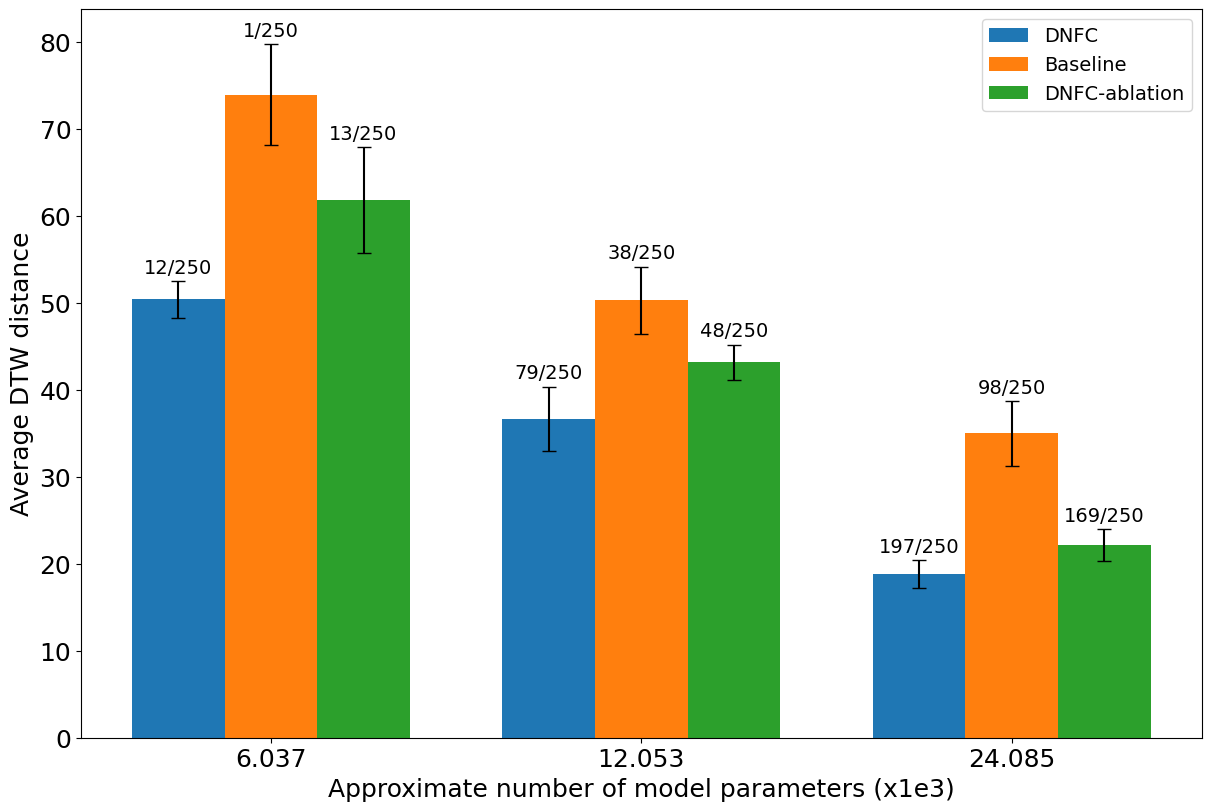

{'DNFC': [50.4077244542309, 36.674822775542225, 18.78821972051519], 'Baseline': [73.93277865907561, 50.27665811476223, 34.97941414975199], 'DNFC-ablation': [61.827673168050374, 43.15222327577146, 22.14774613266682]}
{'DNFC': [2.103640134023299, 3.6648935892565353, 1.6130880467370878], 'Baseline': [5.825706603820789, 3.8878718104417205, 3.6941736623850874], 'DNFC-ablation': [6.0494886087350315, 2.035126090339745, 1.8428257983882514]}


In [11]:
Ys = {
    'DNFC': [x for x in stats_model['dtw_mean']],
    'Baseline': [x for x in stats_base['dtw_mean']],
    'DNFC-ablation': [x for x in stats_abl['dtw_mean']],
}

errors = {
    'DNFC': [x / math.sqrt(len(stats_model['succ_arr'][0])) 
             for x in stats_model['dtw_std']],
    'Baseline': [x / math.sqrt(len(stats_model['succ_arr'][0])) 
                 for x in stats_base['dtw_std']],
    'DNFC-ablation': [x / math.sqrt(len(stats_model['succ_arr'][0])) 
                      for x in stats_abl['dtw_std']],
}

x = np.arange(len(model_params_list))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(12, 8))

for attribute, measurement in Ys.items():
    offset = width * multiplier
    # print(attribute)
    rects = ax.bar(x + offset, measurement, width, label=attribute, yerr=errors[attribute],
                   error_kw={'capsize': 5})
    # ax.bar_label(rects, fmt='%.2f', padding=3)
    if attribute == 'DNFC':
        numerators = stats_model['succ_num']
        denominators = stats_model['eps_num']
    elif attribute == 'Baseline':
        numerators = stats_base['succ_num']
        denominators = stats_base['eps_num']
    elif attribute == 'DNFC-ablation':
        numerators = stats_abl['succ_num']
        denominators = stats_abl['eps_num']
    
    fraction_labels = [f"{int(n)}/{int(d)}" for n, d in zip(numerators, denominators)]

    # Add labels on top of bars
    ax.bar_label(rects, labels=fraction_labels, padding=3, fontsize=label_fontsize)
    
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Average DTW distance")
ax.set_xlabel("Approximate number of model parameters (x1e3)")
# ax.set_title('Robot Endpoint-Target Distance')
ax.set_xticks(x + width, model_params_list)
# ax.legend(loc='upper left', ncols=3)
ax.legend()
# ax.set_ylim(0, 250)
plt.savefig(os.path.join(os.getcwd(), f"paper/dtw_{ds_type}_{episode_no}.png"))
plt.show()
print(Ys)
print(errors)

### Points

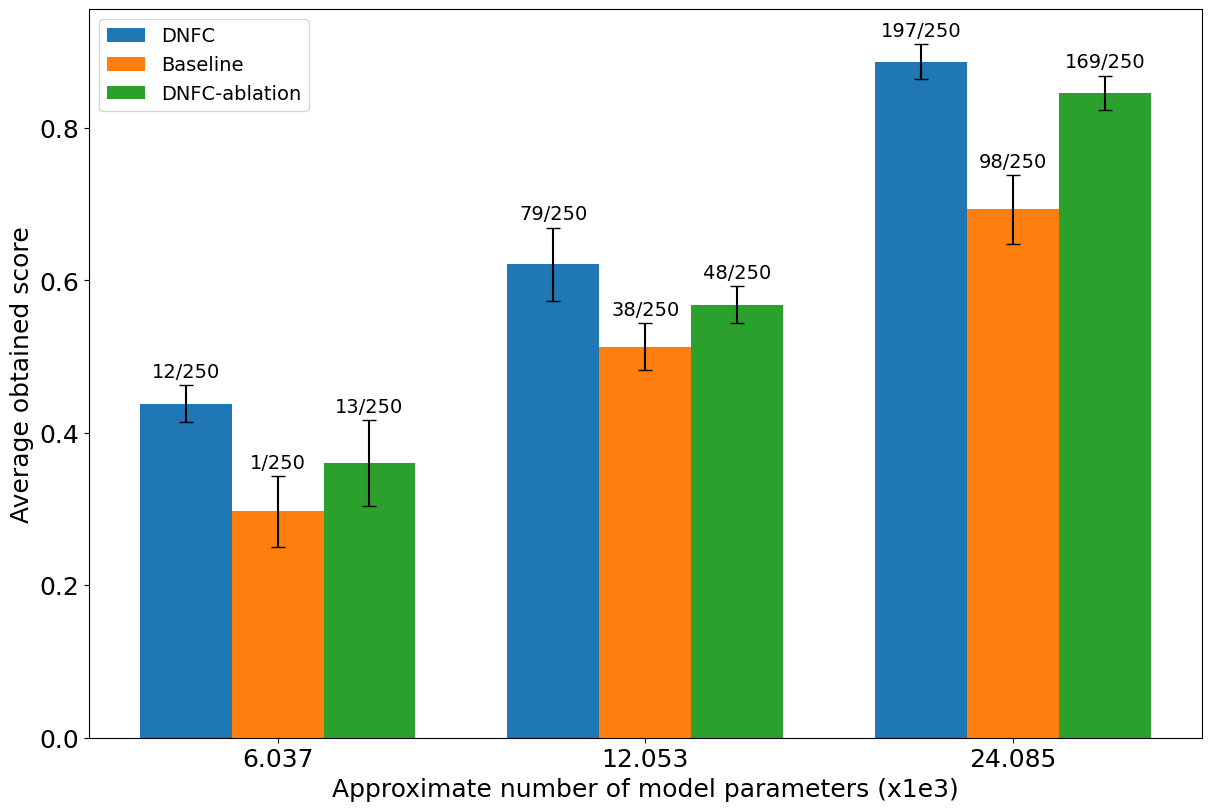

{'DNFC': [0.43800000000000006, 0.6210000000000001, 0.8870000000000001], 'Baseline': [0.29700000000000004, 0.513, 0.693], 'DNFC-ablation': [0.36, 0.5679999999999998, 0.8460000000000001]}
{'DNFC': [0.024212026396446505, 0.0481306093412036, 0.023048258550750034], 'Baseline': [0.04618922433256965, 0.030985659765625635, 0.04464800605228014], 'DNFC-ablation': [0.056647055429994674, 0.02425787386488033, 0.022221111083331944]}


In [12]:
Ys = {
    'DNFC': [x for x in stats_model['succ_mean']],
    'Baseline': [x for x in stats_base['succ_mean']],
    'DNFC-ablation': [x for x in stats_abl['succ_mean']],
}

errors = {
    'DNFC': [x / math.sqrt(len(stats_model['succ_arr'][0]))
             for x in stats_model['succ_std']],
    'Baseline': [x / math.sqrt(len(stats_model['succ_arr'][0]))
                 for x in stats_base['succ_std']],
    'DNFC-ablation': [x / math.sqrt(len(stats_model['succ_arr'][0])) 
                      for x in stats_abl['succ_std']],
}

x = np.arange(len(model_params_list))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(12, 8))

for attribute, measurement in Ys.items():
    offset = width * multiplier
    # print(attribute)
    rects = ax.bar(x + offset, measurement, width, label=attribute, yerr=errors[attribute],
                   error_kw={'capsize': 5})
    # ax.bar_label(rects, fmt='%.2f', padding=3)
    if attribute == 'DNFC':
        numerators = stats_model['succ_num']
        denominators = stats_model['eps_num']
    elif attribute == 'Baseline':
        numerators = stats_base['succ_num']
        denominators = stats_base['eps_num']
    elif attribute == 'DNFC-ablation':
        numerators = stats_abl['succ_num']
        denominators = stats_abl['eps_num']
    
    fraction_labels = [f"{int(n)}/{int(d)}" for n, d in zip(numerators, denominators)]

    # # Add labels on top of bars
    ax.bar_label(rects, labels=fraction_labels, padding=3, fontsize=label_fontsize)
    # for idx, (bar, label) in enumerate(zip(rects, fraction_labels)):
    #     height = bar.get_height()
    #     y_offset = 5 if idx % 2 == 0 else 2  # Alternate height for labels
    #     ax.text(
    #         bar.get_x() + bar.get_width() / 2,
    #         height + y_offset,
    #         label,
    #         ha='center',
    #         va='bottom',
    #         fontsize=10
    #     )
    
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average obtained score')
ax.set_xlabel("Approximate number of model parameters (x1e3)")
# ax.set_title('Robot Endpoint-Target Distance')
ax.set_xticks(x + width, model_params_list)
# ax.legend(loc='upper left', ncols=3)
ax.legend()
# ax.set_ylim(0, 250)
plt.savefig(os.path.join(os.getcwd(), f"paper/pts_{ds_type}_{episode_no}.png"))
plt.show()
print(Ys)
print(errors)

### DTW of completed episodes

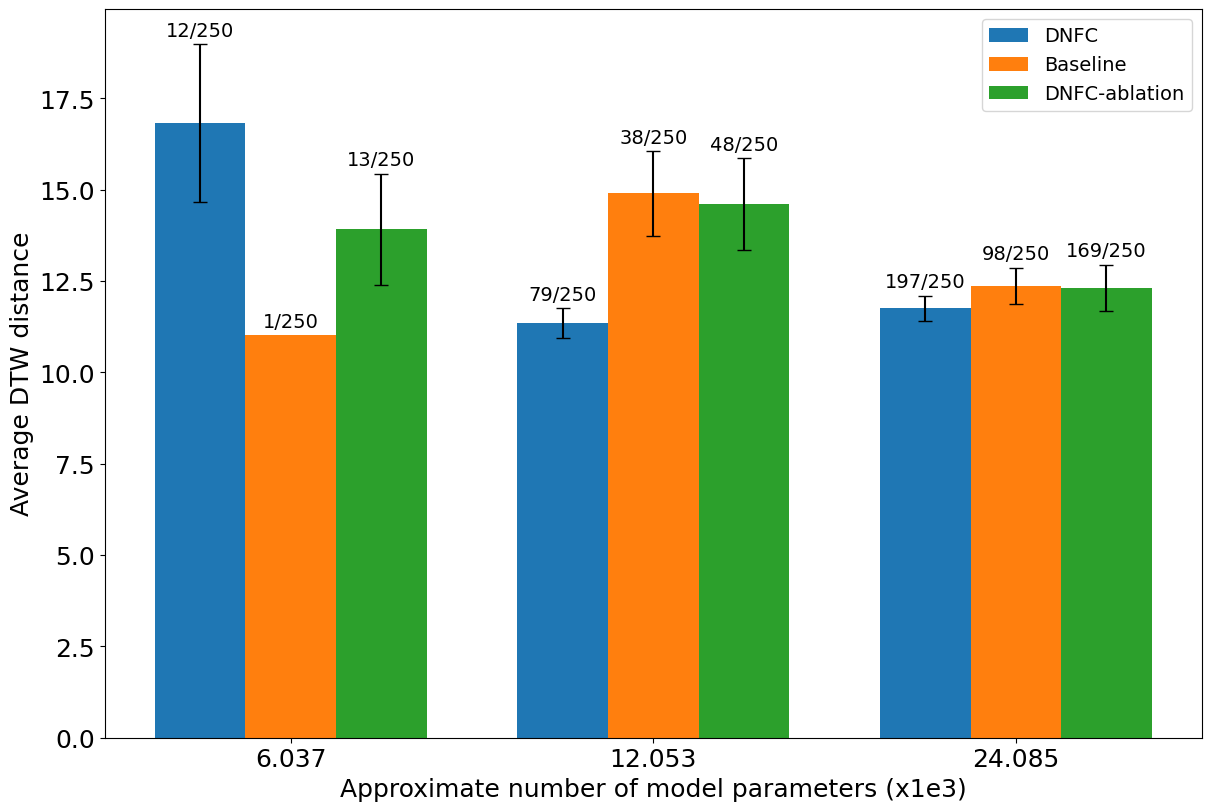

{'DNFC': [16.832167451697362, 11.357705050632212, 11.759740664546745], 'Baseline': [11.019343625196273, 14.898501678657457, 12.36442286295082], 'DNFC-ablation': [13.923396431352465, 14.599643052040843, 12.319905238258002]}
{'DNFC': [2.156557312149484, 0.4024544725494467, 0.34087987551128474], 'Baseline': [nan, 1.1605224362874604, 0.4954586001760404], 'DNFC-ablation': [1.5185578134382696, 1.2605336531736573, 0.6274347273458903]}


In [13]:
Ys = {
    'DNFC': [x for x in stats_model['succ_dtw_mean']],
    'Baseline': [x for x in stats_base['succ_dtw_mean']],
    'DNFC-ablation': [x for x in stats_abl['succ_dtw_mean']],
}

errors = {
    'DNFC': [stats_model['succ_dtw_std'][i] / math.sqrt(stats_model['succ_dtw_num'][i])
             for i in range(len(stats_model['succ_dtw_std']))],
    'Baseline': [stats_base['succ_dtw_std'][i] / math.sqrt(stats_base['succ_dtw_num'][i])
                 for i in range(len(stats_base['succ_dtw_std']))],
    'DNFC-ablation': [stats_abl['succ_dtw_std'][i] / math.sqrt(stats_abl['succ_dtw_num'][i]) 
                      for i in range(len(stats_abl['succ_dtw_std']))],
}

x = np.arange(len(model_params_list))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(12, 8))

for attribute, measurement in Ys.items():
    offset = width * multiplier
    # print(attribute)
    rects = ax.bar(x + offset, measurement, width, label=attribute, yerr=errors[attribute],
                   error_kw={'capsize': 5})
    # ax.bar_label(rects, fmt='%.2f', padding=3)
    if attribute == 'DNFC':
        numerators = stats_model['succ_num']
        denominators = stats_model['eps_num']
    elif attribute == 'Baseline':
        numerators = stats_base['succ_num']
        denominators = stats_base['eps_num']
    elif attribute == 'DNFC-ablation':
        numerators = stats_abl['succ_num']
        denominators = stats_abl['eps_num']
    
    fraction_labels = [f"{int(n)}/{int(d)}" for n, d in zip(numerators, denominators)]

    # Add labels on top of bars
    ax.bar_label(rects, labels=fraction_labels, padding=3, fontsize=label_fontsize)
    
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average DTW distance')
ax.set_xlabel("Approximate number of model parameters (x1e3)")
# ax.set_title('Robot Endpoint-Target Distance')
ax.set_xticks(x + width, model_params_list)
# ax.legend(loc='upper left', ncols=3)
ax.legend()
# ax.set_ylim(0, 250)
plt.savefig(os.path.join(os.getcwd(), f"paper/succ_dtw_{ds_type}_{episode_no}.png"))
plt.show()
print(Ys)
print(errors)

In [14]:
print(stats_model['succ_dtw_mean'])
print(stats_base['succ_dtw_mean'])

[16.832167451697362, 11.357705050632212, 11.759740664546745]
[11.019343625196273, 14.898501678657457, 12.36442286295082]


In [15]:
print(round_means_dnfc)
print(round_means_dnfc["dnfc_dtw"].mean())
print(round_means_base)
print(round_means_base["basel_dtw"].mean())

             dnfc_succ  basel_succ   dnfc_dtw  basel_dtw
train_round                                             
1                  1.0         1.0  11.897694  11.897694
2                  1.0         1.0   9.479732   9.479732
3                  1.0         1.0  14.407827  14.407827
4                  1.0         1.0  11.935410  11.935410
5                  1.0         1.0  11.103260  11.103260
6                  1.0         1.0  14.307872  14.307872
7                  1.0         1.0  12.103560  12.103560
8                  1.0         1.0  11.462784  11.462784
9                  1.0         1.0  15.964590  15.964590
10                 1.0         1.0  10.536324  10.536324
12.319905238258002
             dnfc_succ  basel_succ   dnfc_dtw  basel_dtw
train_round                                             
1                  1.0         1.0  11.897694  11.897694
2                  1.0         1.0   9.479732   9.479732
3                  1.0         1.0  14.407827  14.407827
4           

In [ ]:
bin_no = 10

dnfc_mean = df["dnfc_succ"].mean()
basel_mean = df["basel_succ"].mean()

# Plot histograms for 'dnfc_succ' and 'basel_succ' side by side
plt.figure(figsize=(8, 6))
plt.hist(df["dnfc_succ"], bins=bin_no, alpha=0.7, label='dnfc_succ', edgecolor='black')
plt.hist(df["basel_succ"], bins=bin_no, alpha=0.7, label='basel_succ', edgecolor='black')
# plt.title("Histogram of dnfc_succ and basel_succ", fontsize=14)
# Add vertical dashed lines for mean values
plt.axvline(dnfc_mean, color='blue', linestyle='dashed', 
            linewidth=2, label=f'dnfc_succ mean: {dnfc_mean:.2f}')
plt.axvline(basel_mean, color='orange', linestyle='dashed', 
            linewidth=2, label=f'basel_succ mean: {basel_mean:.2f}')

plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid(axis='y', alpha=0.75)

# plt.savefig(os.path.join(os.getcwd(), "paper/succ_hist.png"))
plt.show()

In [ ]:
bin_no = 20

# Find the common range for both datasets
min_value = min(df["dnfc_dtw"].min(), df["basel_dtw"].min())
max_value = max(df["dnfc_dtw"].max(), df["basel_dtw"].max())

# Create bin edges with equal width
bins = np.linspace(min_value, max_value, bin_no + 1)  # +1 because linspace creates bin edges

dnfc_mean = df["dnfc_dtw"].mean()
basel_mean = df["basel_dtw"].mean()
plt.figure(figsize=(8, 6))
plt.hist(df["dnfc_dtw"], bins=bins, alpha=0.5, label='dnfc_dtw', edgecolor='black')
plt.hist(df["basel_dtw"], bins=bins, alpha=0.5, label='basel_dtw', edgecolor='black')

plt.axvline(dnfc_mean, color='blue', linestyle='dashed', 
            linewidth=2, label=f'dnfc_dtw mean: {dnfc_mean:.2f}')
plt.axvline(basel_mean, color='orange', linestyle='dashed', 
            linewidth=2, label=f'basel_dtw mean: {basel_mean:.2f}')
# plt.title("Histogram of dnfc_succ and basel_succ", fontsize=14)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid(axis='y', alpha=0.75)

# plt.savefig(os.path.join(os.getcwd(), "paper/dtw_hist.png"))
plt.show()


### Latent Space Rep.

In [ ]:
root_dir = "/home/arash/catkin_ws/src/feedback_controller/fbc/neural_network/results/"
root_dir += "trajs:360_blocks:3_triangle_v_7.541K/ep:1000/on_v_custl_const_1e-05"

In [ ]:
file_path = os.path.join(root_dir, "all_states_dnfc")
with open(file_path, 'rb') as f:
    all_states_dnfc = pickle.load(f)

In [ ]:
eps_no = 27

dnfc_data = all_states_dnfc[eps_no]

In [ ]:
joint_vals = [timestep_data[4] for timestep_data in dnfc_data]
timesteps = range(len(joint_vals))

plt.figure(figsize=(10, 6))
plt.plot(timesteps, joint_vals)
plt.xlabel("Timestep")
plt.ylabel("Value")
# plt.title("Fifth Value Across Timesteps")
# plt.legend()
plt.grid(True)
plt.show()

## Loss

In [ ]:
root_dir = "/home/arash/catkin_ws/src/feedback_controller/fbc/neural_network/weights/deniz_weights"
dnfc_dir = os.path.join(root_dir, 
                        "triangle|interp_0.85|cus_los_1e-05|tar_cart|2+2l_lat:sub-nvel_0.008_noise|48.149K_params")
base_dir = os.path.join(root_dir, 
                        "triangle|interp_0.85|mse_los|tar_cart|base|3l_base_0.008_noise|48.287K_params")

dnfc_fpath = os.path.join(dnfc_dir, "train_no_0/loss.csv")
df_dnfc = pd.read_csv(dnfc_fpath)
base_fpath = os.path.join(base_dir, "train_no_0/loss.csv")
df_base = pd.read_csv(base_fpath)

In [ ]:
df_dnfc.head()

In [ ]:
df_base.head()

In [ ]:
# Filter the dataframe for n >= 10
filtered_df = df_dnfc[(df_dnfc["n"] >= 200)] #& (df_dnfc["n"] <= 1000)]
filtered_df_base = df_base[(df_base["n"] >= 200)] #& (df_dnfc["n"] <= 1000)]

# Plot train_loss_torques and val_loss_torques vs n
plt.figure(figsize=(10, 8))
plt.plot(filtered_df["n"], filtered_df["train_loss_torques"], 
         marker='o', linestyle='-', label="Train Trq DNFC")
plt.plot(filtered_df["n"], filtered_df["val_loss_torques"], 
         marker='x', linestyle='-', label="Val Trq DNFC")
# plt.plot(filtered_df["n"], np.log(filtered_df["train_loss_custom"]), 
#          marker='o', linestyle='-', label="Train Cus DNFC")
# plt.plot(filtered_df["n"], np.log(filtered_df["val_loss_cutsom"]), 
#          marker='x', linestyle='-', label="Val Cus DNFC")

plt.plot(filtered_df_base["n"], filtered_df_base["train_loss_torques"], 
         marker='o', linestyle='-', label="Train Trq Base")
plt.plot(filtered_df_base["n"], filtered_df_base["val_loss_torques"], 
         marker='x', linestyle='-', label="Val Trq Base")
plt.xlabel("n")
plt.ylabel("Loss")
# plt.title("Train and Val Loss Torques vs n (n >= 100)")
plt.legend()
plt.grid(True)

loss_path = os.path.join(dnfc_dir, "loss.png")
plt.savefig(loss_path)
plt.show()


## Latent Representations

In [ ]:
def get_file(model_dir, is_not_abl, file_name):
    file_dir = os.path.join(model_dir, f"on_v_custl_mse_1e-05_{is_not_abl}")
    file_path = os.path.join(file_dir, f"{file_name}")
    with open(file_path, 'rb') as f:
        latent_reps = pickle.load(f)
    return latent_reps

def get_csv(model_dir, is_not_abl):
    file_dir = os.path.join(model_dir, f"on_v_custl_mse_1e-05_{is_not_abl}")
    file_path = os.path.join(file_dir, "perf.csv")
    df = pd.read_csv(file_path)  
    return df

def add_train_round(df):
    df['train_round'] = df.groupby('eps_num').cumcount() + 1
    return df

In [ ]:
def plot_latent_reps(latent_reps, latent_reps_abl, states, states_abl,
                     df_perf, df_perf_abl, i_eps, model_dir):
    # Transpose the data to separate each joint
    lat_rep_transp = list(zip(*latent_reps))
    lat_rep_abl_transp = list(zip(*latent_reps_abl))
    states_transp = list(zip(*states))
    states_abl_transp = list(zip(*states_abl))

    # print(len(lat_rep_transp), len(lat_rep_transp[0]))
    # Plot each joint's position over time
    time_steps = range(len(latent_reps))  # Assuming each inner list corresponds to a timestep
    
    colors = [
        'blue', 'green', 'red', 'cyan', 'magenta', #'yellow', 
        'black', 'orange', 'purple', 'brown', 'pink', 'lime', 
        'teal', 'gold'
    ]
    
    # Create a figure with 7 subplots arranged vertically
    fig, axes = plt.subplots(7, 1, figsize=(12, 14), sharex=True)
    fig.tight_layout(pad=0.0)  # Adjust spacing between subplots

    for idx, lat_rep in enumerate(lat_rep_transp[:7]):
        ax = axes[idx]  # Select the subplot corresponding to the current index
        if idx < 7: label_st = f'Jnt.{idx + 1}'
        else: label_st = f'Vel.{(idx%7) + 1}'

        # print(len(lat_rep), len(lat_rep_abl_transp), len(states_transp))
        ax.plot(time_steps, lat_rep, 
                 label=f'Dim{idx + 1}', color=colors[idx])
        ax.plot(time_steps, lat_rep_abl_transp[idx], 
                 label=f'Dim{idx + 1}a', color=colors[idx], linestyle='dashed')
        ax.plot(time_steps, states_transp[idx], 
                 label=label_st, color=colors[idx])#<, linestyle='dashed')
        ax.plot(time_steps, states_abl_transp[idx], 
                 label=f'Jnt.{idx + 1}a', color=colors[idx], linestyle='dotted')
        
        # Add labels and legend to each subplot
        ax.set_ylabel(f'Dim {idx + 1}')
        ax.legend()
        ax.grid(True)

    eps_no = i_eps // 5
    train_no = i_eps % 5
    # Add a common xlabel and adjust layout
    axes[-1].set_xlabel('Time Steps')
    fig.suptitle(f"DNFC: {df_perf['dnfc_succ']}, DNFC-abl: {df_perf_abl['dnfc_succ']}")
    # plt.show()
    plot_dir = os.path.join(model_dir, f'latent_reps')
    if os.path.exists(plot_dir):
        pass
        # print("Latent dir. already exists. Are you trying to generate it again?")
        # sys.exit(1)
    else:
        os.makedirs(plot_dir)
    plot_path = os.path.join(plot_dir, f"eps:{eps_no}_train:{train_no}.png")
    plt.savefig(plot_path)
    plt.close()

In [ ]:
for num_params in model_params_list:
    model_dir = os.path.join(root_dir, f"trajs:360_blocks:3_triangle_v_{num_params}K/ep:1000/")
    latent_reps = get_file(model_dir, True, "all_latent_reps")
    latent_reps_abl = get_file(model_dir, False, "all_latent_reps")
    states_dnfc = get_file(model_dir, True, "all_states_dnfc")
    states_abl = get_file(model_dir, False, "all_states_dnfc")

    df_perf = get_csv(model_dir, True)
    df_perf = add_train_round(df_perf)
    df_perf_abl = get_csv(model_dir, False)
    df_perf_abl = add_train_round(df_perf_abl)
    # print(df_perf_abl.head(10))

    for i_eps in range(len(latent_reps)):
        plot_latent_reps(latent_reps[i_eps], 
                            latent_reps_abl[i_eps], 
                            states_dnfc[i_eps],
                            states_abl[i_eps], 
                            df_perf.loc[i_eps], df_perf_abl.loc[i_eps], i_eps, model_dir)

## Intrinsic to Cartesian

In [ ]:
def intrinsic_to_3d_cart(all_joints_vals):
    x, y, z = [], [], []
    for joints_vals in all_joints_vals:
        my_l = [0, 0]
        for j_val in joints_vals:
            my_l.append(float(j_val))
        p, R = kin.forwardkin(1, np.array(my_l))
        x.append(p[0])
        y.append(p[1])
        z.append(p[2])

    return x, y, z

In [ ]:
def get_end_eff_pos(js):
    my_l = [0, 0]
    for j in js:
        my_l.append(float(j))
    p1, R = kin.forwardkin(1, np.array(my_l))
    return p1

In [ ]:
def load_list_from_file(file_path):
    with open(file_path, 'rb') as f:
        lst = pickle.load(f)
    return lst


In [ ]:
file_root_dir = root_dir +\
    f"{ds_name}_{model_params_list[-1]}K_{ds_type}/ep:4000/on_{model_name}" + "_True" + "_3l_base"

file_path = os.path.join(file_root_dir, "all_states_dnfc")
all_states_dnfc = load_list_from_file(file_path)
print(file_path)
print(len(all_states_dnfc))

In [ ]:
positions = []
for eps_num in range(len(all_states_dnfc)):
    eps_positions = []
    eps_states = all_states_dnfc[eps_num]
    for tms_num in range(len(eps_states)):
        tms_state = eps_states[tms_num]
        pos = get_end_eff_pos(tms_state[:7])
        pos = pos.tolist()
        eps_positions.append(pos)
    positions.append(eps_positions)


In [ ]:
positions_arr = np.array(positions)
positions_arr.shape

In [ ]:
path = os.path.join(file_root_dir, "end_eff_pos.npy")
np.save(path, positions_arr)